# Interactively applying the Variational Method to the Dihydrogen molecule: exploring bonding and anti-bonding

## Exploring the results for the dihydrogen molecule interactively

### Authors:

* [Vinícius Wilian D. Cruzeiro, Ph.D. Student](http://roitberg.chem.ufl.edu)
* [Nicolas C. Polfer, Ph.D.](http://www.chem.ufl.edu/~polfer/)

Department of Chemistry

Physical Chemistry Division

University of Florida

P.O. Box 117200

Gainesville, FL 32611-7200

United States

**Instructions:**
* The reader should follow this notebook in the order that it is presented, executing code cells in consecutive order.
* In order to execute a cell you may click on the cell and then press *Shift+Enter*. The user may also execute all cells at once by clicking on *Cell --> Run All* at the toolbar above.
* **Important:** The cell the shows density plots for the dihydrogen molecule **is only going to execute after the user enters a value for $R$**. In order for this cell to run properly all other code cells before this one **need to be executed**. In order to do that the user may click on the cell that shows the density plots and, before executing it, click on *Cell --> Run All Above* at the toolbar above.

**Note:**
* This work started as a student project for the Quantum Chemistry graduate course (CHM 6470 - Chemical Bonding and Spectra I) at the University of Florida.

### Libraries used in this notebook:

On the first cell we are going to import the libraries used in this notebook as well as call some important functions.

In [1]:
import matplotlib as mpl # matplotlib library for plotting and visualization
import matplotlib.pylab as plt # pylab from the matplotlib library for plotting and visualization
import numpy as np # numpy library for numerical manipulation, especially suited for data arrays
import scipy as sci # scipy library with scientic tools
from scipy.optimize import fmin # Used to minimize a function
from scipy.special import erf # Error function

In the next cell we are shutting down eventual warnings displayed by IPython. This cell is optional.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Executing this cell prints on the screen the versions of IPython, Python and its libraries on your computer. Please check if the versions are up-to-date to facilitate a smooth running of the program.

In [9]:
import sys # checking the version of Python
import IPython # checking the version of IPython
print("Python version = {}".format(sys.version))
print("IPython version = {}".format(IPython.__version__))
print("Matplotlib version = {}".format(plt.__version__))
print("Numpy version = {}".format(np.__version__))
print("Scipy version = {}".format(sci.__version__))

Python version = 2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython version = 5.1.0
Matplotlib version = 1.11.1
Numpy version = 1.11.1
Scipy version = 0.18.1


### Special calls:

This cell configures `matplotlib` to show figures embedded within the cells it was executed from, instead of opening a new window for each figure.

In [4]:
%matplotlib inline

## Expressions from the paper

We will start from the expressions presented on the paper for the variational integral $W$, probability density $\wp(x,y,z)$ for the bonding or anti-bonding wavefunctions, and probability density $\wp_{2H}(x,y,z)$ for the two hydrogen atoms as if they were isolated.

For $W$ we have:
$$ W = \left\{ 3\alpha \pm (3 - \alpha R^2) \alpha e^{-\alpha R^2} -4\sqrt{\frac{2\alpha}{\pi}} \left[ 1 + \frac{1}{2R} \sqrt{\frac{\pi}{2\alpha}} erf(R\sqrt{2\alpha}) \right] \mp \frac{8}{R} e^{-\alpha R^2} erf\left(R\sqrt{\frac{\alpha}{2}}\right) + 2\sqrt{\frac{\alpha}{\pi}} \left[ \frac{1}{2R} \sqrt{\frac{4\pi}{\alpha}} erf\left(R\sqrt{\frac{\alpha}{4}}\right) \pm e^{-\alpha R^2} \right] \right\} \frac{1}{1 \pm e^{-\alpha R^2}} \tag{20}$$

For $\wp(x,y,z)$ we have:
$$\wp(x,y,z) = \frac{\int{\left| \Psi(\vec{r},\vec{r}_2) \right|^2 d\tau_2}}{\int \int{\left| \Psi(\vec{r}_1,\vec{r}_2) \right|^2 d\tau_1 d\tau_2}} 
\\ = \frac{1}{2} \left( \frac{2 \alpha}{\pi} \right) ^\frac{3}{2} \frac{e^{-2\alpha (x^2 + y^2)}}{1 \pm e^{-\alpha R^2}} \left[ e^{-2 \alpha (z - \frac{R}{2})^2} \pm 2 e^{-2 \alpha z^2} e^{-\alpha R^2} + e^{-2 \alpha (z + \frac{R}{2})^2} \right] \tag{21}$$

For $\wp_{2H}(x,y,z)$ we have:
$$\wp_{2H}(x,y,z) = \frac{\left|\phi_A(\vec{r})\right|^2+\left|\phi_B(\vec{r})\right|^2}{2} = \left(\frac{2\alpha_H}{\pi}\right)^{\frac{3}{2}} \frac{e^{-2\alpha_H\left(x^2+y^2\right)}}{2} \left[e^{-2\alpha_H\left(z+\frac{R}{2}\right)^2}+e^{-2\alpha_H\left(z-\frac{R}{2}\right)^2}\right] \tag{22}$$

## Visualising the Results Interactively

Let's define $W$ as an *Ipython* function:

In [5]:
def W(alpha,R,mul): #valid for multiplicity (mul) 1 or 3
    """Variational integral for the dihydrogen molecule"""
    if mul==1:
        mul_factor=+1
    elif mul==3:
        mul_factor=-1        
    else:
        print("mul must be equal to 1 or 3")
        raise ValueError
    #the expression for W is coded in multiple steps
    eq = 3.*alpha+mul_factor*(3.-alpha*(R**2))*alpha*np.exp(-alpha*(R**2))
    eq += -4.*np.sqrt(2.*alpha/np.pi)*(1.+(1./(2.*R))*np.sqrt(np.pi/(2.*alpha))\
                                       *erf(R*np.sqrt(2.*alpha)))
    eq += -mul_factor*(8./R)*np.exp(-alpha*(R**2))*erf(R*np.sqrt(alpha/2.))
    eq += 2.*np.sqrt(alpha/np.pi)*( (1./(2.*R))*np.sqrt(4.*np.pi/alpha)\
                    *erf(R*np.sqrt(alpha/4.)) + mul_factor*np.exp(-alpha*(R**2)) )
    eq *= 1./(1.+mul_factor*np.exp(-alpha*(R**2)))
    return eq

Let's define $\wp (x,y,z)$ as an *Ipython* function:

In [6]:
def prob(x,y,z,alpha,R,mul): #valid for multiplicity (mul) 1 or 3
    """Probability density for the dihydrogen molecule"""
    if mul==1:
        mul_factor=+1
    elif mul==3:
        mul_factor=-1
    else:
        print("mul must be equal to 1 or 3")
        raise ValueError
    prob = 0.5*((2.*alpha/np.pi)**1.5)*np.exp(-2.*alpha*(x**2+y**2))*(np.exp(-2.*alpha*((z-R/2.)**2)) \
                + mul_factor*2.*np.exp(-2.*alpha*(z**2))*np.exp(-alpha*(R**2)) \
                + np.exp(-2.*alpha*((z+R/2.)**2)))/(1.+mul_factor*np.exp(-alpha*(R**2)))
    return prob

Let's now plot $W$ as a function of $\alpha$ for a given value of $R$ and find the values of $\alpha$ that minimizes $W$ (for that $R$ and for both the bonding and anti-bonding wavefunctions). We will also make plots of the probability densities using the values of $\alpha$ that minimizes $W$. For comparison we will also make density plots based on the atoms as if isolated.

Enter the value (in Bohrs) for R  = 1

The minimized values are:
  For spin-multiplicity 1 (bonding):      alpha_min = 0.4494, W_min = -1.8480
  For spin-multiplicity 3 (anti-bonding): alpha_min = 0.2770, W_min = -1.1218


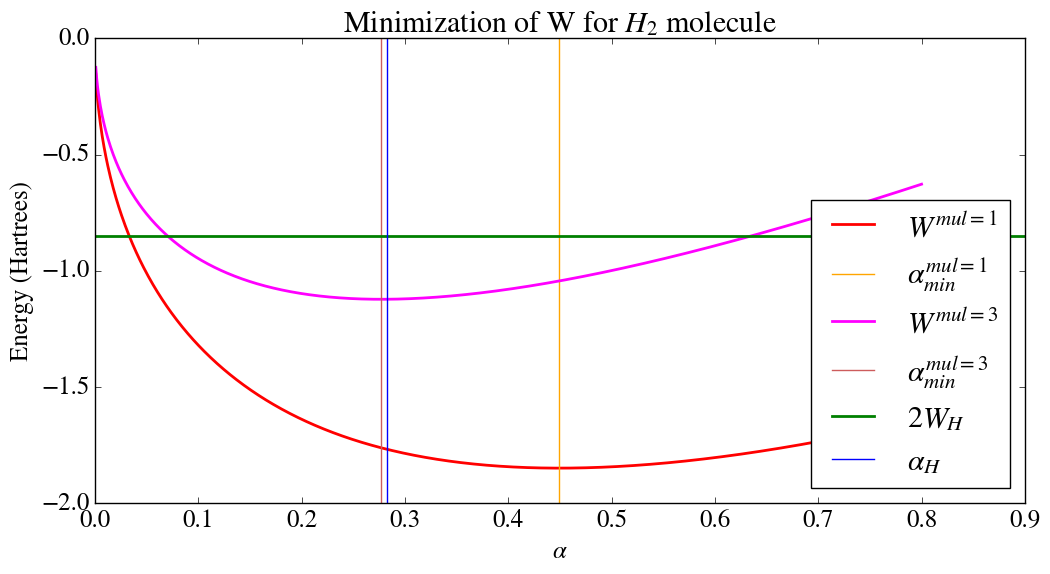

The probability density of the bonding, anti-bonding and two isolated atoms wavefunctions in the xz (y = 0) plane is:


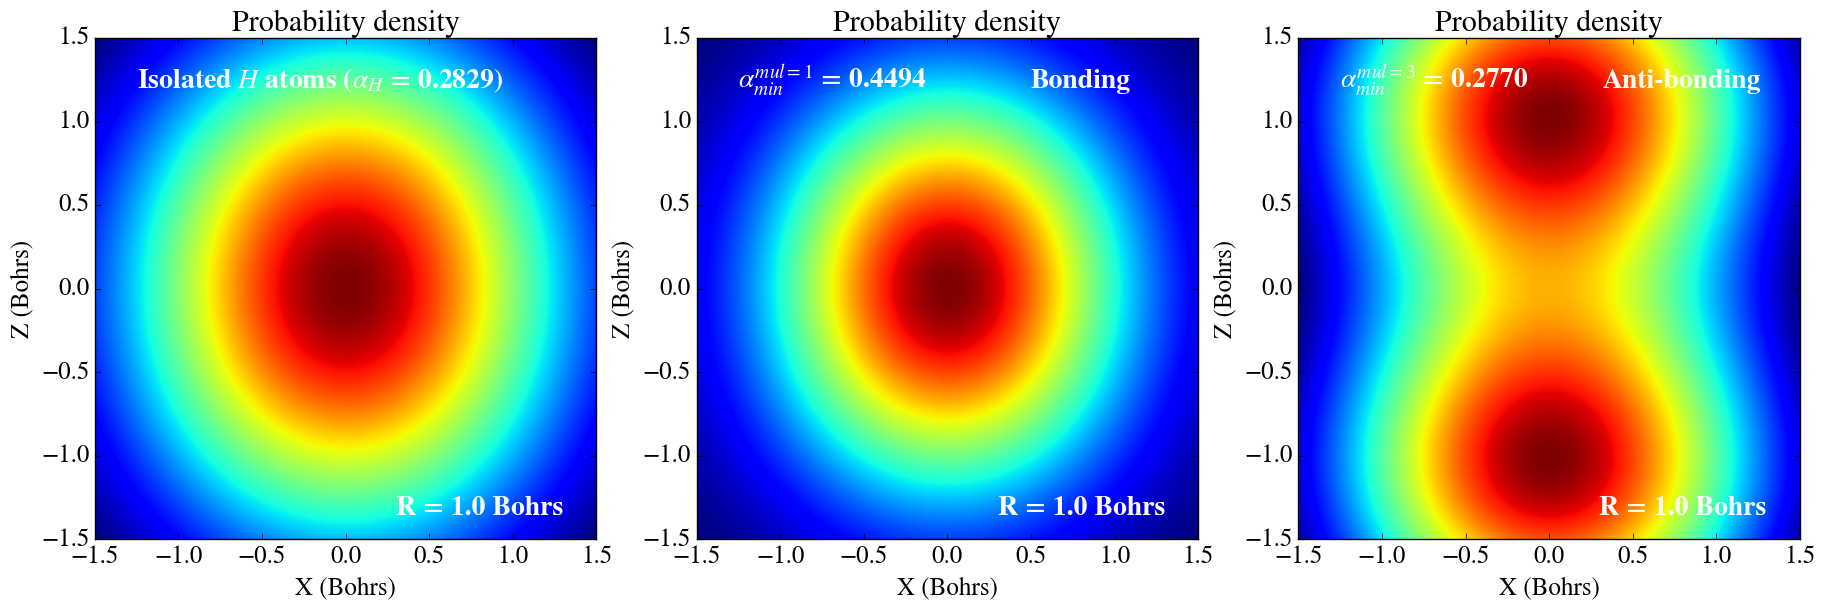

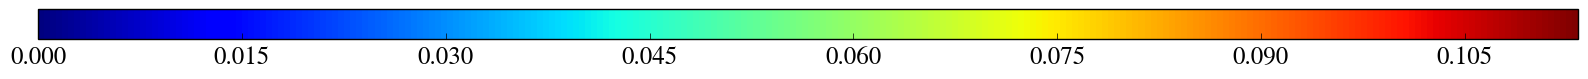

Probability density as a function of z (x = y = 0). The plot is shown for both multiplicities and for both hydrogen atoms as if they were isolated:


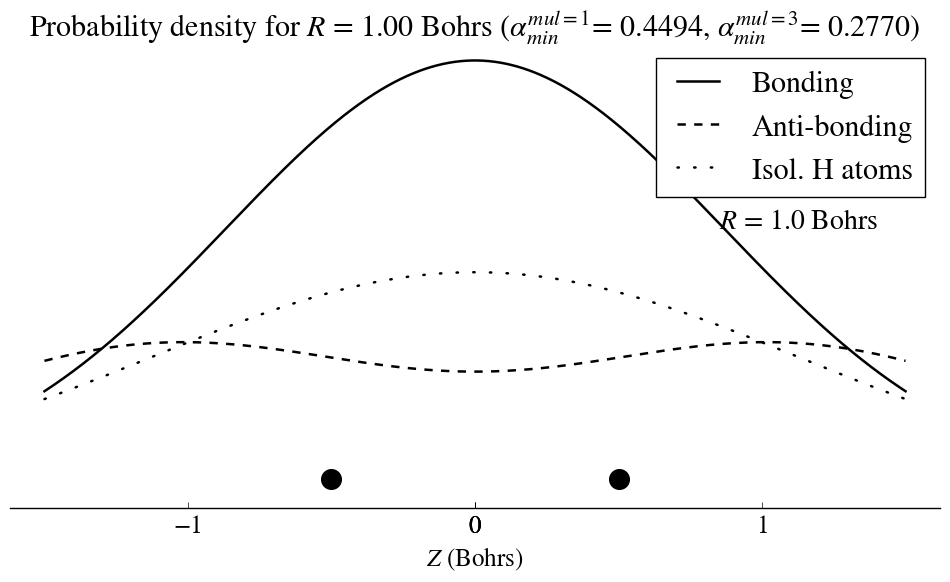

In [7]:
R = float(input("Enter the value (in Bohrs) for R  = "))

w1_alpha = lambda x: W(x,R,1)
w3_alpha = lambda x: W(x,R,3)

x0 = 0.2829

alp1_min = fmin(w1_alpha, x0, disp=False) #function to minimize W as a function of alpha for mul = 1, initial guess = alpha_H_atom
alp3_min = fmin(w3_alpha, x0, disp=False) #function to minimize W as a function of alpha for mul = 3, initial guess = alpha_H_atom
print("\nThe minimized values are:")
print("  For spin-multiplicity 1 (bonding):      alpha_min = %.4f, W_min = %.4f" % (alp1_min, W(alp1_min,R,1)))
print("  For spin-multiplicity 3 (anti-bonding): alpha_min = %.4f, W_min = %.4f" % (alp3_min, W(alp3_min,R,3)))

# Plotting the first graph
plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
alpha = np.linspace(0, 0.8, 900, endpoint=True)
W1_plot = W(alpha,R,1)
W3_plot = W(alpha,R,3)
ax.set_ylabel(r'Energy (Hartrees)')
ax.set_xlabel(r'$\alpha$')
ax.plot(alpha,W1_plot, linewidth=2, color="red", label=r"$W^{mul=1}$")
plt.axvline(x=alp1_min, linewidth=1, color="orange", label=r"$\alpha_{min}^{mul=1}$")
ax.plot(alpha,W3_plot, linewidth=2, color="magenta", label=r"$W^{mul=3}$")
plt.axvline(x=alp3_min, linewidth=1, color="indianred", label=r"$\alpha_{min}^{mul=3}$")
plt.axhline(y=-8/(3*np.pi), linewidth=2, color="green", label=r"$2W_H$")
plt.axvline(x=0.2829, linewidth=1, color="blue", label=r"$\alpha_{H}$")
plt.title('Minimization of W for $H_2$ molecule')
ax.legend(loc=4)
plt.show()

print("The probability density of the bonding, anti-bonding and two isolated atoms wavefunctions in the xz (y = 0) plane is:")

def f2H(x,z): return ((2.*x0/np.pi)**(1.5))*(np.exp(-2*x0*(x**2.+(z-R/2.)**2.))+np.exp(-2*x0*(x**2.+(z+R/2.)**2.)))/2.
# probability density for 2 hydrogen atoms isolated
def f1(x,z): return prob(x,0.,z,alp1_min,R,1)
def f3(x,z): return prob(x,0.,z,alp3_min,R,3)

delta = R/300.
x=np.arange(-1.5*R, 1.5*R, delta)
z=np.arange(-1.5*R, 1.5*R, delta)
X, Z = np.meshgrid(x, z)

fig, axes = plt.subplots(1, 3, figsize=(22,8))
axes[0].imshow(f2H(X,Z), origin='lower', extent=[-1.5*R, 1.5*R, -1.5*R, 1.5*R])
axes[0].set_title(r'Probability density')
axes[0].set_ylabel(r'Z (Bohrs)')
axes[0].set_xlabel(r'X (Bohrs)')
str1="R = "+str(R)+" Bohrs"
str3=r'Isolated $H$ atoms ($\alpha_H$ = 0.2829)'
axes[0].text( 0.30*R, -1.35*R, str1, fontsize=20, fontweight="bold", color="white")
axes[0].text(-1.25*R,  1.20*R, str3, fontsize=20, fontweight="bold", color="white")
axes[1].imshow(f1(X,Z), origin='lower', extent=[-1.5*R, 1.5*R, -1.5*R, 1.5*R])
axes[1].set_title(r'Probability density')
axes[1].set_ylabel(r'Z (Bohrs)')
axes[1].set_xlabel(r'X (Bohrs)')
str1="R = "+str(R)+" Bohrs"
str2="Bonding"
str3=r'$\alpha_{min}^{mul=1}$ = %.4f' % (alp1_min)
axes[1].text( 0.30*R, -1.35*R, str1, fontsize=20, fontweight="bold", color="white")
axes[1].text( 0.50*R,  1.20*R, str2, fontsize=20, fontweight="bold", color="white")
axes[1].text(-1.25*R,  1.20*R, str3, fontsize=20, fontweight="bold", color="white")

im = axes[2].imshow(f3(X,Z), origin='lower', extent=[-1.5*R, 1.5*R, -1.5*R, 1.5*R])
axes[2].set_title(r'Probability density')
axes[2].set_ylabel(r'Z (Bohrs)')
axes[2].set_xlabel(r'X (Bohrs)')
str1="R = "+str(R)+" Bohrs"
str2="Anti-bonding"
str3=r'$\alpha_{min}^{mul=3}$ = %.4f' % (alp3_min)
axes[2].text( 0.30*R, -1.35*R, str1, fontsize=20, fontweight="bold", color="white")
axes[2].text( 0.32*R,  1.20*R, str2, fontsize=20, fontweight="bold", color="white")
axes[2].text(-1.25*R,  1.20*R, str3, fontsize=20, fontweight="bold", color="white")

# Plotting the colorbar for the density plots
fig = plt.figure(figsize=(22,3))
colbar = fig.add_axes([0.05, 0.80, 0.7, 0.10])
norm = mpl.colors.Normalize(vmin=0., vmax=prob(0.,0.,R/2.,alp1_min,R,1))
mpl.colorbar.ColorbarBase(colbar, norm=norm, orientation='horizontal')
plt.show()

plt.show()

print("Probability density as a function of z (x = y = 0). The plot is shown for both multiplicities and for both hydrogen atoms as if they were isolated:")

plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
ax.spines['right'].set_color('none')
ax.xaxis.tick_bottom()
ax.spines['left'].set_color('none')
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_color('none')
str1="$R$ = "+str(R)+" Bohrs"
ymax = max(((2.*x0/np.pi)**1.5)/2.,prob(0.,0.,R/2.,alp1_min,R,1),prob(0.,0.,R/2.,alp1_min,R,3),prob(0.,0.,0.,alp1_min,R,1))
ax.text(0.85*R,  0.60*ymax, str1, fontsize=20, color="black")
ax.set_xticks([-int(1.5*R), -int(0.75*R), 0, int(0.75*R), int(1.5*R)])
Z = np.linspace(-1.5*R, 1.5*R, 900,endpoint=True)
def prob_2H(z): return ((2.*x0/np.pi)**(1.5))*(np.exp(-2*x0*((z-R/2.)**2.))+np.exp(-2*x0*((z+R/2.)**2.)))/2.
prob_plot1 = prob(0.,0.,Z,alp1_min,R,1)
prob_plot3 = prob(0.,0.,Z,alp3_min,R,3)
ax.set_xlabel(r'$Z$ (Bohrs)')
ax.plot(Z,prob_plot1, color="black", label=r"Bonding", linewidth=1.8)
ax.plot(Z,prob_plot3, color="black", label=r"Anti-bonding", linewidth=1.8, linestyle='--')
ax.plot(Z,prob_2H(Z), color="black", label=r"Isol. H atoms", linewidth=1.8, dash_capstyle='round', dashes=[1,11])
plt.scatter(-R/2,0.0,200.0,'black')
plt.scatter(R/2, 0.0,200.0,'black')
ax.margins(0.04)
plt.title(r'Probability density for $R$ = %.2f Bohrs ($\alpha_{min}^{mul=1}$= %.4f, $\alpha_{min}^{mul=3}$= %.4f)' % (R,alp1_min,alp3_min))
ax.legend(loc=1)
plt.show()

Let's now plot $\alpha_{min}$ as a function of $R$. We will also plot the corresponding $W_{min}$ and all its contributions as a function $R$, as well as the total energy $W_{min} + 1/R$. In the total energy, the calculated minimum electronic energy $W_{min}$ (at each value of R) is corrected for the nucleus-nucleus repulsion energy (at that R).

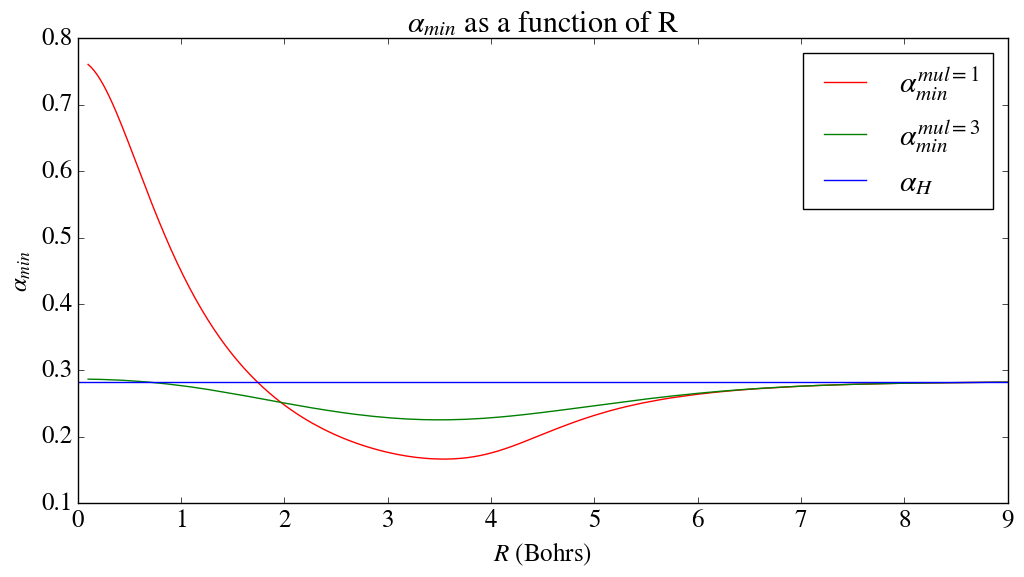

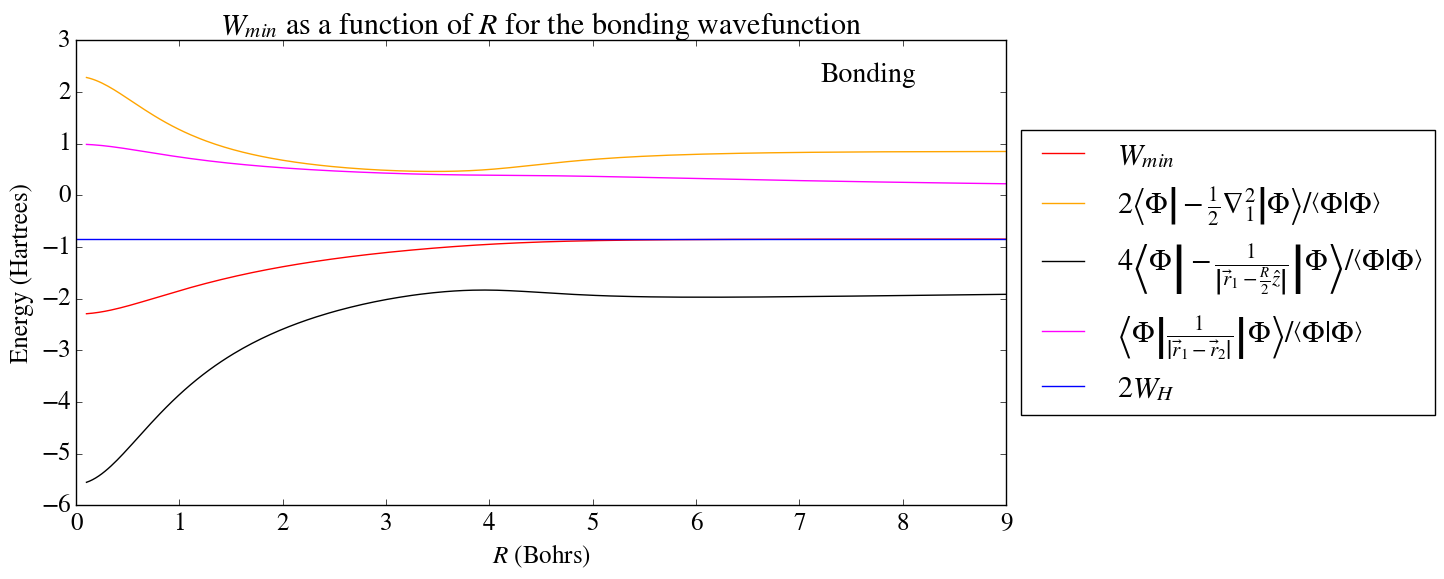

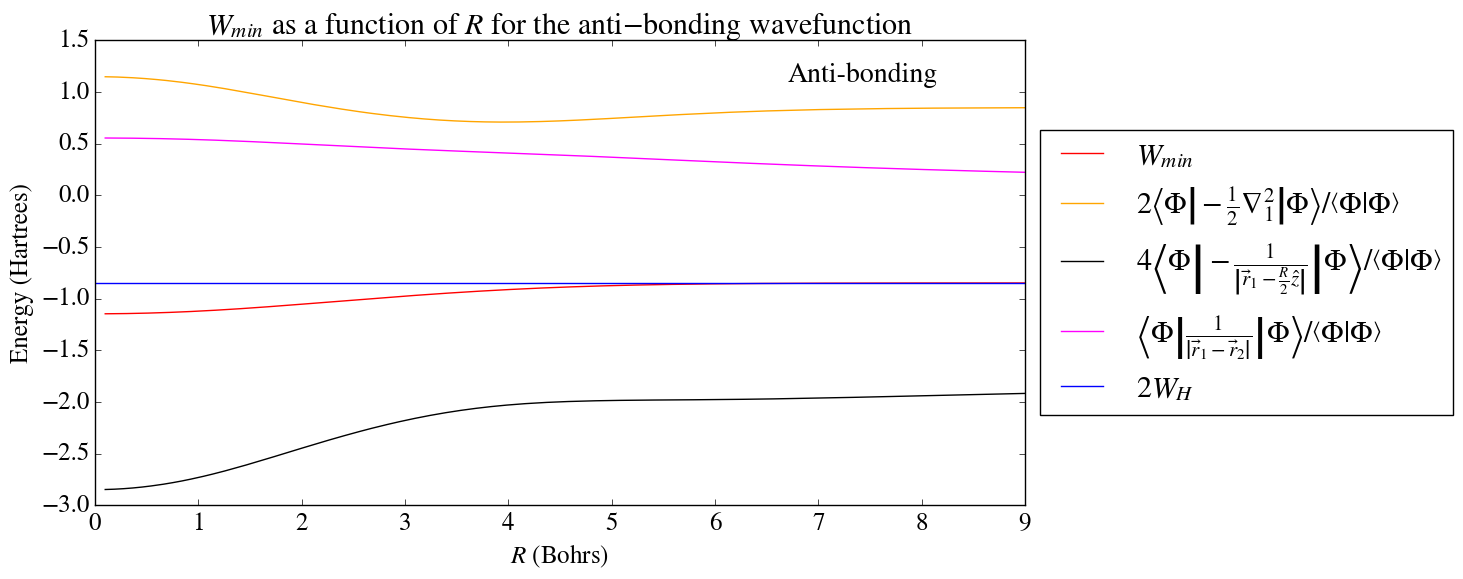

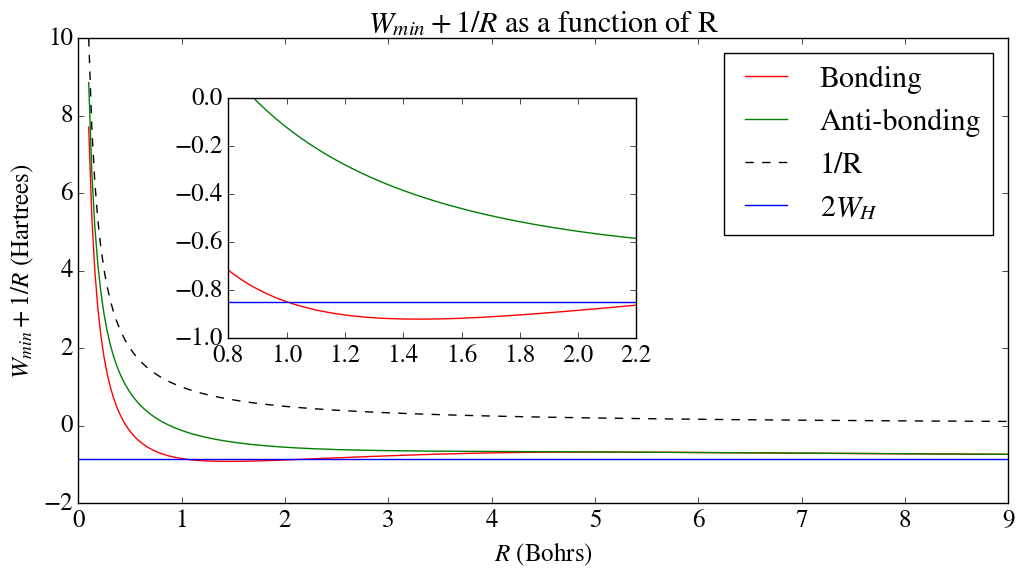

In [8]:
X = np.zeros(301, dtype="float64")
Yalp_1 = np.zeros(301, dtype="float64")
Yalp_3 = np.zeros(301, dtype="float64")
YW_1 = np.zeros(301, dtype="float64")
YW_3 = np.zeros(301, dtype="float64")
Ykin_1 = np.zeros(301, dtype="float64")
Ykin_3 = np.zeros(301, dtype="float64")
Yen_1 = np.zeros(301, dtype="float64")
Yen_3 = np.zeros(301, dtype="float64")
Yee_1 = np.zeros(301, dtype="float64")
Yee_3 = np.zeros(301, dtype="float64")
YWR_1 = np.zeros(301, dtype="float64")
YWR_3 = np.zeros(301, dtype="float64")
NR = np.zeros(301, dtype="float64")
x0 = 0.2829
for i in range(0,301):
    R = 0.1 + 8.9*float(i)/300.0
    X[i] = R
    w_alpha = lambda x: W(x,R,1) #note that alpha is a variable now, and multiplicity set to 1
    alp_min = fmin(w_alpha, x0, disp=False)
    Yalp_1[i] = alp_min
    YW_1[i] = W(alp_min,R,1)
    mul_factor=+1
    Ykin_1[i] = (3.*alp_min+mul_factor*(3.-alp_min*(R**2))*alp_min*np.exp(-alp_min*(R**2)))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    Yen_1[i] = (-4.*np.sqrt(2.*alp_min/np.pi)*(1.+(1./(2.*R))*np.sqrt(np.pi/(2.*alp_min))*erf(R*np.sqrt(2.*alp_min)))-mul_factor*(8./R)*np.exp(-alp_min*(R**2))*erf(R*np.sqrt(alp_min/2.)))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    Yee_1[i] = (2.*np.sqrt(alp_min/np.pi)*( (1./(2.*R))*np.sqrt(4.*np.pi/alp_min)*erf(R*np.sqrt(alp_min/4.)) + mul_factor*np.exp(-alp_min*(R**2)) ))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    YWR_1[i] = W(alp_min,R,1)+1/R
    w_alpha = lambda x: W(x,R,3) #note that multiplicity set to 3
    alp_min = fmin(w_alpha, x0, disp=False)
    Yalp_3[i] = alp_min
    YW_3[i] = W(alp_min,R,3)
    mul_factor=-1
    Ykin_3[i] = (3.*alp_min+mul_factor*(3.-alp_min*(R**2))*alp_min*np.exp(-alp_min*(R**2)))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    Yen_3[i] = (-4.*np.sqrt(2.*alp_min/np.pi)*(1.+(1./(2.*R))*np.sqrt(np.pi/(2.*alp_min))*erf(R*np.sqrt(2.*alp_min)))-mul_factor*(8./R)*np.exp(-alp_min*(R**2))*erf(R*np.sqrt(alp_min/2.)))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    Yee_3[i] = (2.*np.sqrt(alp_min/np.pi)*( (1./(2.*R))*np.sqrt(4.*np.pi/alp_min)*erf(R*np.sqrt(alp_min/4.)) + mul_factor*np.exp(-alp_min*(R**2)) ))/(1.+mul_factor*np.exp(-alp_min*(R**2)))
    YWR_3[i] = W(alp_min,R,3)+1/R
    NR[i] = 1/R
    

plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
ax.set_ylabel(r'$\alpha_{min}$')
ax.set_xlabel(r'$R$ (Bohrs)')
ax.plot(X,Yalp_1, color="red", label=r"$\alpha_{min}^{mul=1}$")
ax.plot(X,Yalp_3, color="green", label=r"$\alpha_{min}^{mul=3}$")
plt.axhline(y=0.2829, linewidth=1, color="blue", label=r"$\alpha_{H}$")
plt.title(r'$\alpha_{min}$ as a function of R')
ax.legend(loc=1)
plt.show()

plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
ax.set_ylabel(r'Energy (Hartrees)')
ax.set_xlabel(r'$R$ (Bohrs)')
ax.plot(X,YW_1, color="red", label=r"$W_{min}$")
ax.plot(X,Ykin_1, color="orange", label=r"$2 \left\langle \Phi \left| -\frac{1}{2}\nabla_1^2 \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.plot(X,Yen_1, color="black", label=r"$4 \left\langle \Phi \left| - \frac{1}{\left| \vec{r}_1-\frac{R}{2}\hat{z}\right|} \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.plot(X,Yee_1, color="magenta", label=r"$\left\langle \Phi \left| \frac{1}{\left| \vec{r}_1-\vec{r}_2\right|} \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.text(7.2, 2.2, "Bonding", fontsize=20, color="black")
plt.axhline(y=-8/(3*np.pi), linewidth=1, color="blue", label=r"$2W_H$")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('$W_{min}$ as a function of $R$ for the bonding wavefunction')
plt.show()

plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
ax.set_ylabel(r'Energy (Hartrees)')
ax.set_xlabel(r'$R$ (Bohrs)')
ax.plot(X,YW_3, color="red", label=r"$W_{min}$")
ax.plot(X,Ykin_3, color="orange", label=r"$2 \left\langle \Phi \left| -\frac{1}{2}\nabla_1^2 \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.plot(X,Yen_3, color="black", label=r"$4 \left\langle \Phi \left| - \frac{1}{\left| \vec{r}_1-\frac{R}{2}\hat{z}\right|} \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.plot(X,Yee_3, color="magenta", label=r"$\left\langle \Phi \left| \frac{1}{\left| \vec{r}_1-\vec{r}_2\right|} \right| \Phi \right\rangle / \left\langle \Phi | \Phi \right\rangle$")
ax.text(6.7, 1.1, "Anti-bonding", fontsize=20, color="black")
plt.axhline(y=-8/(3*np.pi), linewidth=1, color="blue", label=r"$2W_H$")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('$W_{min}$ as a function of $R$ for the anti-bonding wavefunction')
plt.show()

plt.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig, ax = plt.subplots(figsize=(12,6))
#main figure
ax.set_ylabel(r'$W_{min}+1/R$ (Hartrees)')
ax.set_xlabel(r'$R$ (Bohrs)')
ax.plot(X,YWR_1, color="red", label=r"Bonding")
ax.plot(X,YWR_3, color="green", label=r"Anti-bonding")
ax.plot(X,NR, '--', color="black", label=r"1/R")
ax.axhline(y=-8/(3*np.pi), linewidth=1, color="blue", label=r"$2W_H$")
ax.set_title('$W_{min}+1/R$ as a function of R')
ax.legend(loc=1)
#inset
inset_ax = fig.add_axes([0.25, 0.4, 0.34, 0.4])
inset_ax.plot(X,YWR_1, color="red", label=r"Bonding")
inset_ax.plot(X,YWR_3, color="green", label=r"Anti-bonding")
inset_ax.axhline(y=-8/(3*np.pi), linewidth=1, color="blue", label=r"$2W_H$")
inset_ax.set_xlim([0.8, 2.2])
inset_ax.set_ylim([-1.0, 0.0])
plt.show()

Important conclusions from these plots:

For $\alpha_{min}$
* For the bonding wavefunction, $\alpha_{min}$ varies significantly with internuclear distance $R$
* For the bonding wavefunction, $\alpha_{min}$  < $\alpha_H$ at larger values of $R$ (>~ 1.73 Bohrs)
* For the bonding wavefunction, $\alpha_{min}$  > $\alpha_H$ at smaller values of $R$ (<~ 1.73 Bohrs)
* For the anti-bonding wavefunction, $\alpha_{min}$  < $\alpha_H$ except for $R$ <~ 0.64 Bohrs

For  $W_{min}$
* The electronic energy $W_{min}$ increases in magnitude with decreasing $R$

For $W_{min}+1/R$
* However, as the nuclear repulsion decreases with increasing $R$, this effect counter-balances $W_{min}$
* For the bonding wavefunction, there is a minimum at $R_{eq}=1.45$ Bohrs
* The bond energy is thus approximated to be -44.946 kcal/mol